In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score,roc_auc_score
import lightgbm as lgb
from mochi import runXGB,f_beta_01,runLGBM
from sklearn.ensemble import RandomForestClassifier as RFC #sklearn 0.19

In [2]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))
print(config.feature_dict.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'chi_test_result', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']
dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])


In [3]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
             config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
            config.feature_dict['hcc_target_encoding']+
                    config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)
#trade_tt_mat[trade_tt_mat==-10]=np.nan

validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [4]:
lgbm_features = config.model_features['Lgbm_best_171']
rf_features = config.model_features['rf_best_361']

In [5]:
lgbm_features_ori_index = [features.index(x) for x in lgbm_features]
trade_tt_lgbm = trade_tt_mat[:,lgbm_features_ori_index]

In [7]:
rf_features_ori_index = [features.index(x) for x in rf_features]
trade_tt_rf = trade_tt_mat[:,rf_features_ori_index]

### find best para for lgbm on subsample,colsample_bytree,max_depth

In [8]:
def find_para_lgbm(bagging_fraction,feature_fraction,num_leaves):
    cv_scores = []
    cv_result = []
    models = []
    
    i = 0
    
    for train_indice,val_indice in validation_tuple_list:
        #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
        #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
        result_dict = {}
        
        #filter the features
        dev_X, val_X = trade_tt_lgbm[train_indice], trade_tt_lgbm[val_indice]
        dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
       
        preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=lgbm_features,verbose=100,eta=0.02,
                              early_stop=100,num_rounds=10000,watch_dict=result_dict,feval = None,
                              bagging_fraction=bagging_fraction,feature_fraction=feature_fraction,num_leaves=num_leaves)
        """
        preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                              early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
         """
        
        #result_f_beta = f_beta_01(val_y.values, preds>0.5)
        result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
        
        cv_scores.append(result_f_beta)
        cv_result.append(result_dict)
        models.append(model)
        i+=1
        print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))
    
    print('The mean of the cv_scores is:',np.mean(cv_scores))
    return np.mean(cv_scores)

In [ ]:
# find the best subsample and colsample_bytree 
subsample_list = [0.25,0.5,0.75]
colsample_bytree_list = [0.25,0.5,0.75]

searched_list = []

for subsample in subsample_list:
    for colsample_bytree in colsample_bytree_list:
        searched_list.append((subsample,colsample_bytree,find_para_lgbm(subsample,colsample_bytree,16)))

In [ ]:
searched_list

In [ ]:
searched_list

In [ ]:
#find the best number of leaves
num_of_leaves_list = [4,8,16,32,64]
searched_list = []

for nol in num_of_leaves_list:
    searched_list.append((nol,find_para_lgbm(0.75,0.25,nol)))

In [ ]:
searched_list

In [ ]:
find_para_lgbm(0.75,0.25,128)

In [9]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_lgbm[train_indice], trade_tt_lgbm[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
       
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=lgbm_features,verbose=100,eta=0.02,
                              early_stop=None,num_rounds=400,watch_dict=result_dict,feval = f_beta_01,
                          bagging_fraction=0.75,feature_fraction=0.25,num_leaves=64)
    """
    preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
     """
    
    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[100]	train's auc: 0.998539	train's fbeta_score_01: 0.955321	test's auc: 0.989618	test's fbeta_score_01: 0.903609
[200]	train's auc: 0.999741	train's fbeta_score_01: 0.978745	test's auc: 0.990555	test's fbeta_score_01: 0.914821
[300]	train's auc: 0.999991	train's fbeta_score_01: 0.997001	test's auc: 0.990099	test's fbeta_score_01: 0.915408
[400]	train's auc: 1	train's fbeta_score_01: 0.999986	test's auc: 0.990209	test's fbeta_score_01: 0.926837
f_beta score for the turn 1 is 0.926836881204
[100]	train's auc: 0.999179	train's fbeta_score_01: 0.971124	test's auc: 0.963289	test's fbeta_score_01: 0.889416
[200]	train's auc: 0.999826	train's fbeta_score_01: 0.985455	test's auc: 0.965382	test's fbeta_score_01: 0.90991
[300]	train's auc: 0.999999	train's fbeta_score_01: 0.999947	test's auc: 0.965941	test's fbeta_score_01: 0.911523
[400]	train's auc: 1	train's fbeta_score_01: 0.999987	test's auc: 0.967559	test's fbeta_score_01: 0.940728
f_beta score for the turn 2 is 0.940728196444
[100]	train

In [35]:
#finding the best iteration
pd_list = []
for dic in cv_result:
    pd_list.append(pd.DataFrame(dic['test']))
    
for i in range(len(pd_list)):
    pd_list[i].columns = pd_list[i].columns+'_'+str(i)
validation_result = pd.concat(pd_list,axis = 1)
validation_result['auc_avg'] = validation_result.apply(lambda x : np.mean([x.auc_0,x.auc_1,x.auc_2,x.auc_3,x.auc_4]),axis = 1)

validation_result['fbeta_avg'] = validation_result.apply(lambda x : np.mean([x.fbeta_score_01_0,x.fbeta_score_01_1,
                                                                     x.fbeta_score_01_2,x.fbeta_score_01_3,
                                                                    x.fbeta_score_01_4]),axis=1)

print(validation_result['auc_avg'].idxmax())
print(validation_result['fbeta_avg'].idxmax())

348
398


In [9]:
train_X = trade_tt_lgbm[config.train_2_6_index]
test_X = trade_tt_lgbm[config.trade_train_size:]
train_y = train_labels[config.train_2_6_index]

preds, _ = runLGBM(train_X, train_y, test_X,feature_names=lgbm_features,verbose=100,eta=0.02,
                              early_stop=None,num_rounds=390,watch_dict=None,feval = f_beta_01,
                          bagging_fraction=0.75,feature_fraction=0.25,num_leaves=64)

result_path = '../../kaggleData/JD_logging/result/'
test_rowkey = pd.read_pickle(data_path+'trade_test_rowkey.pkl')
pred_label = pd.Series(preds > 0.5)
result_set = pd.DataFrame(test_rowkey)
result_set['is_risk'] = pred_label.astype(int)

print(result_set.shape)

pd.to_pickle(pred_label,result_path+'test_overfit_400.pkl')
result_set.to_csv(result_path+'test_overfit_400.csv',index=False,header=False)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


(17875, 2)


In [11]:
preds_lgbm = preds
print(preds.shape)

(17875,)


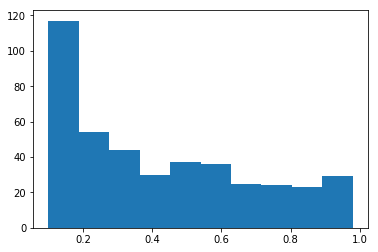

In [14]:
plt.hist(preds_lgbm[preds_lgbm>0.1])
plt.show()

### find the best para for random forest

In [23]:
def find_para_rf(max_depth,max_features):
   

    fbetas = []
    auc_results = []
    
    for train_indice,val_indice in validation_tuple_list:
        
        #filter the validation values
        dev_X, val_X = trade_tt_rf[train_indice], trade_tt_rf[val_indice]
        dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values
    
        classifier = RFC(500,class_weight='balanced',random_state =33,n_jobs = -1,max_depth = max_depth,
                        max_features = max_features)
        
        classifier.fit(dev_X,dev_y)
        
        #feature_importance += classifier.feature_importances_
        
        preds = classifier.predict(val_X)
            
        fbetas.append(fbeta_score(val_y, preds > 0.5, 0.1)) 
    
        auc_results.append(roc_auc_score(val_y,preds))
        
        print('turn passed')
    
    return np.mean(fbetas)

In [17]:
len(rf_features)

361

In [ ]:
# find the best subsample and colsample_bytree 
md_list = [None,16,32,64,128]
mf_list = ['auto','log2',None,0.3,0.5,0.7]

searched_list = []

for max_depth in md_list:
    for max_feature in mf_list:
        print('running parameters are',max_depth,max_feature)
        searched_list.append((max_depth,max_feature,find_para_rf(max_depth,max_feature)))

turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn passed
turn

KeyboardInterrupt: 

In [29]:
sorted(searched_list,key = lambda x :x[2],reverse = True)

[(32, 'log2', 0.95665674074676321),
 (None, 'log2', 0.956507904571681),
 (64, 'log2', 0.956507904571681),
 (32, 'auto', 0.9522667639052752),
 (None, 'auto', 0.9519876425979007),
 (64, 'auto', 0.9519876425979007),
 (None, 0.3, 0.94548860845559679),
 (64, 0.3, 0.94548860845559679),
 (32, 0.3, 0.94282717913181491),
 (None, 0.5, 0.93019149420747305),
 (64, 0.5, 0.93019149420747305),
 (16, 'auto', 0.93016481698103293),
 (None, 0.7, 0.92660387979309988),
 (32, 0.5, 0.92633383101805844),
 (16, 0.3, 0.9252307575428258),
 (16, 'log2', 0.92220236680174128),
 (32, 0.7, 0.92180864047072397),
 (16, 0.5, 0.90751640990414117),
 (32, None, 0.90020676134758248),
 (None, None, 0.89858219792700622),
 (64, None, 0.89858219792700622),
 (16, 0.7, 0.89110991727867084),
 (16, None, 0.85132848860918686)]

In [27]:
print('test')

test


In [49]:
train_X = trade_tt_lgbm[config.train_2_6_index]
test_X = trade_tt_lgbm[config.trade_train_size:]
train_y = train_labels[config.train_2_6_index]

classifier = RFC(1000,class_weight='balanced',random_state =33,n_jobs = -1,max_depth = None,
                        max_features = 'log2')

classifier.fit(train_X,train_y)

preds_rf = classifier.predict(test_X)

In [50]:
result_path = '../../kaggleData/JD_logging/result/'
test_rowkey = pd.read_pickle(data_path+'trade_test_rowkey.pkl')

#combine preds_rf and preds_lgbm by simple averaging

In [51]:
preds = 0.3*preds_rf + 0.7*preds_lgbm


In [52]:
print(np.sum(preds_rf>0.5))
print(np.sum(preds_lgbm>0.5))
print(np.sum(preds>0.5))

24
156
81


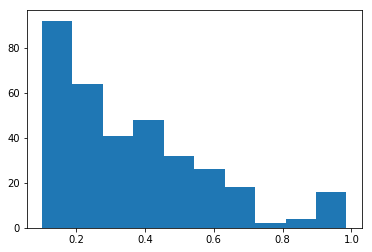

In [53]:
plt.hist(preds[preds>0.1])
plt.show()

In [54]:
pred_label = pd.Series(preds > 0.5)
result_set = pd.DataFrame(test_rowkey)
result_set['is_risk'] = pred_label.astype(int)

print(result_set.shape)

pd.to_pickle(pred_label,result_path+'test_add_rf_3_7_400.pkl')
result_set.to_csv(result_path+'test_add_rf_3_7_400.csv',index=False,header=False)

(17875, 2)
